# Supervised Learning Classification Model - Testing if change in one day average price and seven day average can predict whether NFT price increases

## Imports

Making the necessary imports

In [1]:
import pandas as pd 
import os 
from dotenv import load_dotenv
import requests 
import json 
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


## Importing the API

See if the .env file is working correctly

In [2]:
load_dotenv()

True

In [3]:
api_key = os.getenv('BLOCKSPAN_API_KEY')

Retrieve the API and gather the data in a data frame.

In [4]:
url = "https://api.blockspan.com/v1/exchanges/collectionsranking?chain=eth-main&exchange=opensea&ranking=seven_day_volume&page_size=100"
headers = {
    "accept": "application/json",
    "X-API-KEY": api_key
}

In [5]:
response = requests.get(url, headers=headers).json()
#print(json.dumps(response, indent=4, sort_keys=True))

In [6]:
nft_df = pd.DataFrame(response['results'])
nft_df.head()

,key,name,description,update_at,total_volume,one_day_volume,seven_day_volume,thirty_day_volume,total_sales,one_day_sales,seven_day_sales,thirty_day_sales,total_average_price,one_day_average_price,seven_day_average_price,thirty_day_average_price,contracts
0,valhalla,Valhalla,Valhalla is a crypto native brand for gamers. ...,2022-12-16T17:51:27.963Z,10516.441160783988,353.08722300000005,4180.216349646825,10516.441160783963,11686,275,3308,11686,0.8999179497504697,1.2839535381818183,1.2636687876804187,0.8999179497504675,[{'contract_address': '0x231d3559aa848bf10366f...
1,art-blocks,Art Blocks,Art Blocks is dedicated to bringing compelling...,2022-12-15T19:49:23.602Z,463304.69361787103,281.12792500000006,2136.789362268989,9127.35848823819,207755,200,1662,6494,2.230053156929417,1.4056396250000003,1.2856735031702702,1.4055063887031396,[{'contract_address': '0xa7d8d9ef8d8ce8992df33...
2,mutant-ape-yacht-club,Mutant Ape Yacht Club,The MUTANT APE YACHT CLUB is a collection of u...,2022-12-16T18:15:46.957Z,472543.1316879749,282.6715,2080.838033833333,8005.18593613333,36148,20,135,558,13.072455784219732,14.133574999999999,15.413615065432097,14.346211355077653,[{'contract_address': '0x60e4d786628fea6478f78...
3,cryptopunks,CryptoPunks,"CryptoPunks launched as a fixed set of 10,000 ...",2022-12-16T15:56:56.311Z,1075395.2970093382,227.9,2045.7800000000002,13467.440000000002,22055,3,31,199,48.75970514664875,75.96666666666667,65.99290322580646,67.67557788944725,[{'contract_address': '0xb47e3cd837ddf8e4c57f0...
4,boredapeyachtclub,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,2022-12-16T17:23:46.013Z,697584.0968490699,287.78,1836.93244832,10673.866214819995,27518,4,25,135,25.350101637076456,71.945,73.4772979328,79.06567566533329,[{'contract_address': '0xbc4ca0eda7647a8ab7c20...


## Setting the target for ML

Calculating if the NFT price increases or decreases

In [7]:
nft_df['change'] = nft_df['one_day_average_price'].astype(float) - nft_df['seven_day_average_price'].astype(float)
nft_df.head()
#If positive, then stock increased
#If negative, stock fell

,key,name,description,update_at,total_volume,one_day_volume,seven_day_volume,thirty_day_volume,total_sales,one_day_sales,seven_day_sales,thirty_day_sales,total_average_price,one_day_average_price,seven_day_average_price,thirty_day_average_price,contracts,change
0,valhalla,Valhalla,Valhalla is a crypto native brand for gamers. ...,2022-12-16T17:51:27.963Z,10516.441160783988,353.08722300000005,4180.216349646825,10516.441160783963,11686,275,3308,11686,0.8999179497504697,1.2839535381818183,1.2636687876804187,0.8999179497504675,[{'contract_address': '0x231d3559aa848bf10366f...,0.020285
1,art-blocks,Art Blocks,Art Blocks is dedicated to bringing compelling...,2022-12-15T19:49:23.602Z,463304.69361787103,281.12792500000006,2136.789362268989,9127.35848823819,207755,200,1662,6494,2.230053156929417,1.4056396250000003,1.2856735031702702,1.4055063887031396,[{'contract_address': '0xa7d8d9ef8d8ce8992df33...,0.119966
2,mutant-ape-yacht-club,Mutant Ape Yacht Club,The MUTANT APE YACHT CLUB is a collection of u...,2022-12-16T18:15:46.957Z,472543.1316879749,282.6715,2080.838033833333,8005.18593613333,36148,20,135,558,13.072455784219732,14.133574999999999,15.413615065432097,14.346211355077653,[{'contract_address': '0x60e4d786628fea6478f78...,-1.280040
3,cryptopunks,CryptoPunks,"CryptoPunks launched as a fixed set of 10,000 ...",2022-12-16T15:56:56.311Z,1075395.2970093382,227.9,2045.7800000000002,13467.440000000002,22055,3,31,199,48.75970514664875,75.96666666666667,65.99290322580646,67.67557788944725,[{'contract_address': '0xb47e3cd837ddf8e4c57f0...,9.973763
4,boredapeyachtclub,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,2022-12-16T17:23:46.013Z,697584.0968490699,287.78,1836.93244832,10673.866214819995,27518,4,25,135,25.350101637076456,71.945,73.4772979328,79.06567566533329,[{'contract_address': '0xbc4ca0eda7647a8ab7c20...,-1.532298


In [8]:
nft_df = nft_df

Cleaning up the dataframe. Dropping unesessary columns and assigning NFTs that increased in price a 1 and NFTS that fell in price a 0 in the 'target' column. 

In [9]:
nft_df['target'] = nft_df['change'].apply(lambda x: 0 if x <= 0 else 1)

In [10]:
new_nft_df = nft_df.set_index('key')
new_nft_df = nft_df.drop(columns=['update_at','name','description','contracts','key'])

Visualizing the dataframe.

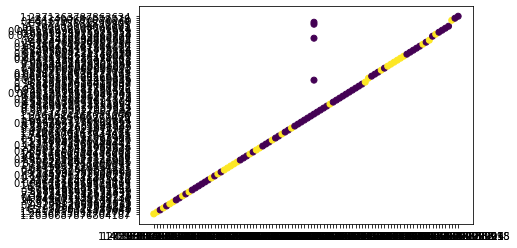

In [11]:
plt.scatter(
    # Put the user download date along the x-axis
    x = new_nft_df['one_day_average_price'],
    # Put the user download location along the y-axis
    y = new_nft_df['seven_day_average_price'],
    # Plot the binary y variable (whether the user made a transaction) as the color
    c=new_nft_df['target']
 )

# Show the plot
plt.show()

## Creating the supervised learning model.

In [12]:
# The y variable should focus on the target column
y = new_nft_df['target'].astype(float)
# The X variable should include all features except the target
x = new_nft_df.drop(columns=['target']).astype(float)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y)

In [14]:
#Scaling data sets
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
#trans X train and test sets using scaler
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [15]:
# Declare a logistic regression model.
# Apply a random_state of 9 to the model
logistic_regression_model = LogisticRegression(random_state=9)
logistic_regression_model

LogisticRegression(random_state=9)

In [16]:
# Fit and save the logistic regression model using the training data
lr_model = logistic_regression_model.fit(X_train, y_train)

In [17]:
#Generate training predictions
training_predictions = lr_model.predict(X_train)

#Generate testing predictions
testing_predictions = logistic_regression_model.predict(X_test)

## Creating the Confusion Matrix

In [18]:
# Create and save the confustion matrix for the training data
training_matrix = confusion_matrix(y_train, training_predictions)

# Print the confusion matrix for the training data
print(training_matrix)

[[46  2]
 [19  8]]


In [19]:
# Create and save the confustion matrix for the testing data
test_matrix = confusion_matrix(y_test, testing_predictions)

# Print the confusion matrix for the testing data
print(test_matrix)

[[18  0]
 [ 4  3]]


In [20]:
# Create and save the training classifiction report
training_report = classification_report(y_train, training_predictions)

# Print the training classification report
print(training_report)

              precision    recall  f1-score   support

         0.0       0.71      0.96      0.81        48
         1.0       0.80      0.30      0.43        27

    accuracy                           0.72        75
   macro avg       0.75      0.63      0.62        75
weighted avg       0.74      0.72      0.68        75



In [21]:
# Create and save the testing classifiction report
testing_report = classification_report(y_test, testing_predictions)

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90        18
         1.0       1.00      0.43      0.60         7

    accuracy                           0.84        25
   macro avg       0.91      0.71      0.75        25
weighted avg       0.87      0.84      0.82        25



## Comparing predictions to the real data

In [22]:
target_only = new_nft_df['target']

# Convert those predictions (and actual values) to a DataFrame
results_df = pd.DataFrame({"prediction": testing_predictions.astype(int)})

In [23]:
outcome_df = pd.concat([nft_df, results_df], axis=1)
outcome_df = outcome_df.dropna()

In [24]:
outcome_df.head()

,key,name,description,update_at,total_volume,one_day_volume,seven_day_volume,thirty_day_volume,total_sales,one_day_sales,seven_day_sales,thirty_day_sales,total_average_price,one_day_average_price,seven_day_average_price,thirty_day_average_price,contracts,change,target,prediction
0,valhalla,Valhalla,Valhalla is a crypto native brand for gamers. ...,2022-12-16T17:51:27.963Z,10516.441160783988,353.08722300000005,4180.216349646825,10516.441160783963,11686,275,3308,11686,0.8999179497504697,1.2839535381818183,1.2636687876804187,0.8999179497504675,[{'contract_address': '0x231d3559aa848bf10366f...,0.020285,1,0.0
1,art-blocks,Art Blocks,Art Blocks is dedicated to bringing compelling...,2022-12-15T19:49:23.602Z,463304.69361787103,281.12792500000006,2136.789362268989,9127.35848823819,207755,200,1662,6494,2.230053156929417,1.4056396250000003,1.2856735031702702,1.4055063887031396,[{'contract_address': '0xa7d8d9ef8d8ce8992df33...,0.119966,1,0.0
2,mutant-ape-yacht-club,Mutant Ape Yacht Club,The MUTANT APE YACHT CLUB is a collection of u...,2022-12-16T18:15:46.957Z,472543.1316879749,282.6715,2080.838033833333,8005.18593613333,36148,20,135,558,13.072455784219732,14.133574999999999,15.413615065432097,14.346211355077653,[{'contract_address': '0x60e4d786628fea6478f78...,-1.280040,0,0.0
3,cryptopunks,CryptoPunks,"CryptoPunks launched as a fixed set of 10,000 ...",2022-12-16T15:56:56.311Z,1075395.2970093382,227.9,2045.7800000000002,13467.440000000002,22055,3,31,199,48.75970514664875,75.96666666666667,65.99290322580646,67.67557788944725,[{'contract_address': '0xb47e3cd837ddf8e4c57f0...,9.973763,1,0.0
4,boredapeyachtclub,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,2022-12-16T17:23:46.013Z,697584.0968490699,287.78,1836.93244832,10673.866214819995,27518,4,25,135,25.350101637076456,71.945,73.4772979328,79.06567566533329,[{'contract_address': '0xbc4ca0eda7647a8ab7c20...,-1.532298,0,0.0


## Conclusions

The predictions resulting from the change in one day average price and seven day average price cannot accurately predict the trajectory of NFT price in this model. However, it was a good introduction and our team would like experiemnting with different variables/metrics in the future.